In [2]:
!pip install hdbscan
!pip install umap-learn

     |████████████████████████████████| 6.4MB 7.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311665 sha256=a969cfefe499b20481917e55126e5813ff14475d20d7de7b869e2000d50bfd82
  Stored in directory: /root/.cache/pip/wheels/42/63/fb/314ad6c3b270887a3ecb588b8e5aac50b0fad38ff89bb6dff2
Successfully built hdbscan
     |████████████████████████████████| 81kB 5.0MB/s 
     |████████████████████████████████| 1.2MB 8.0MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=16eb3de847f2d21ab0eb16ce45423345a46c51d28dd088cc7e32ef970ab850d4
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=440d1b7a53d4268e9648729e552a746b7877da5e399d66a4

In [3]:
import numpy as np
np.random.seed(42)
import random
random.seed(42)

from sklearn.datasets import fetch_20newsgroups

import nltk, string, itertools, time
import matplotlib.pyplot as plt

from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from string import punctuation

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import metrics
from sklearn.metrics.cluster import contingency_matrix, homogeneity_score, v_measure_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

from scipy.optimize import linear_sum_assignment
import umap


In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
stop_words_skt = text.ENGLISH_STOP_WORDS
stop_words_en = stopwords.words('english')
combined_stopwords = set.union(set(stop_words_en),set(stop_words_skt))
#Question 9
dataset_20 = fetch_20newsgroups(subset='all',shuffle=True, remove=('headers', 'footers'), random_state=42)
tfidf_vect_20 = TfidfVectorizer(stop_words=combined_stopwords,min_df=3)
X_train_tfidf_20 = tfidf_vect_20.fit_transform(dataset_20.data) # making the tfidf matrix
print(X_train_tfidf_20.shape)

y_true_20 = dataset_20.target

km_20 = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=30)
y_pred_20 = km_20.fit_predict(TruncatedSVD(n_components=50,random_state=0).fit_transform(X_train_tfidf_20))
con_mat_20 = contingency_matrix(y_true_20,y_pred_20)

(18846, 45338)


In [6]:
def plot_contingency_table_20(cm, title='Contingency Table', cmap=plt.cm.YlOrBr):
    plt.gcf().clear()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    tick_marks = np.arange(20)
    number_labels = [x for x in range(1,21)]
    plt.xticks(tick_marks, number_labels)
    plt.yticks(tick_marks, number_labels)
    
    plt.ylabel('Cluster Class', fontsize=12)
    plt.xlabel('Actual Class', fontsize=12)
    plt.gcf().set_size_inches(10.0,10.0)
    plt.show()

In [7]:
# reorder to maximize along diagonal
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_20, y_pred_20)
rows, cols = linear_sum_assignment(cm, maximize=True)
new_cm = cm[rows[:,np.newaxis], cols]

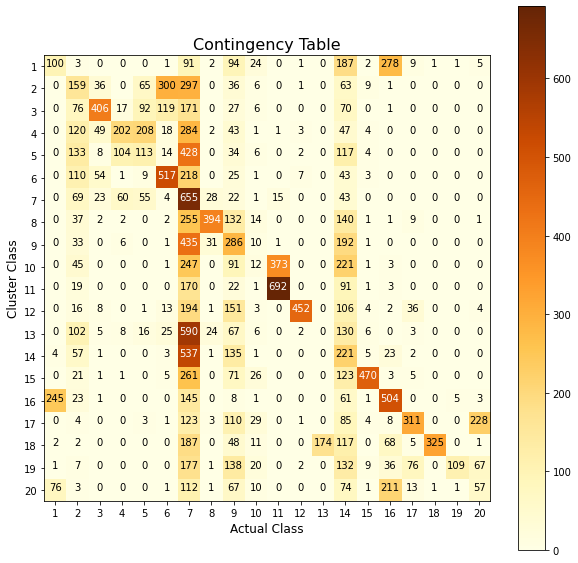

In [8]:
plot_contingency_table_20(new_cm)

In [9]:
from sklearn.cluster import AgglomerativeClustering

reducer = umap.UMAP(metric="cosine", n_components=5, disconnection_distance=2)
embedding = reducer.fit_transform(X_train_tfidf_20)

for linkage in ('ward', 'single'):
    print('-'*20, "Linkage:", linkage, '-'*20)

    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=20)
    clusterPredict = clustering.fit_predict(embedding)

    print("Homogeneity score is:", homogeneity_score(dataset_20.target, clusterPredict))
    print("Completness score is:", completeness_score(dataset_20.target, clusterPredict))
    print("V measure score is:", v_measure_score(dataset_20.target, clusterPredict))
    print("Adjusted Random score is:", adjusted_rand_score(dataset_20.target, clusterPredict))
    print("Adjusted Mutual Info score is:", adjusted_mutual_info_score(dataset_20.target, clusterPredict))

-------------------- Linkage: ward --------------------
Homogeneity score is: 0.5524358503005741
Completness score is: 0.5873188165494134
V measure score is: 0.5693435249793215
Adjusted Random score is: 0.41684135754736373
Adjusted Mutual Info score is: 0.5678999743898119
-------------------- Linkage: single --------------------
Homogeneity score is: 0.016183264812533495
Completness score is: 0.3688634793882109
V measure score is: 0.031006185386674757
Adjusted Random score is: 0.0005152719300290414
Adjusted Mutual Info score is: 0.02588434910394128


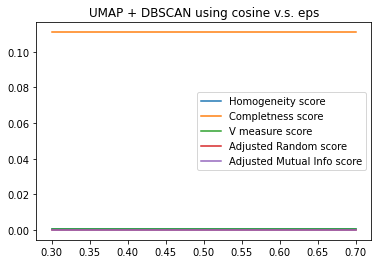

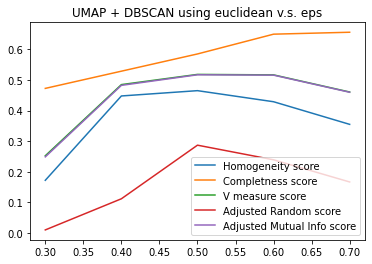

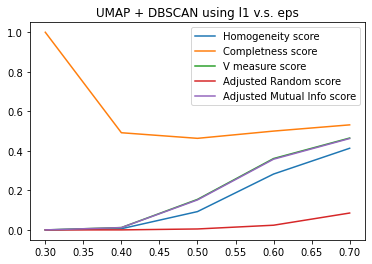

In [10]:
# Question 14
from sklearn.cluster import DBSCAN

umap_homos = []
umap_comp = []
umap_v_measure = []
umap_adj_rand = []
umap_adj_mutual_info = []

epsVals = [x*0.1 for x in range(3, 8)]
metrics = ["cosine", "euclidean", "l1"]

for metric_ in metrics:
  for epsVal in epsVals:
    clustering = DBSCAN(min_samples=100, eps=epsVal, metric=metric_)
    clustering_data = clustering.fit(embedding)
    
    umap_homos.append(homogeneity_score(dataset_20.target, clustering_data.labels_))
    umap_comp.append(completeness_score(dataset_20.target, clustering_data.labels_))
    umap_v_measure.append(v_measure_score(dataset_20.target, clustering_data.labels_))
    umap_adj_rand.append(adjusted_rand_score(dataset_20.target, clustering_data.labels_))
    umap_adj_mutual_info.append(adjusted_mutual_info_score(dataset_20.target, clustering_data.labels_))

numEpsVals = len(epsVals)
for index, metric_ in enumerate(metrics):
  plt.title('UMAP + DBSCAN using ' + metric_ + " v.s. eps") 
  plt.plot(epsVals, umap_homos[index*numEpsVals:(index+1)*numEpsVals], label='Homogeneity score')
  plt.plot(epsVals, umap_comp[index*numEpsVals:(index+1)*numEpsVals], label='Completness score')
  plt.plot(epsVals, umap_v_measure[index*numEpsVals:(index+1)*numEpsVals], label='V measure score')
  plt.plot(epsVals, umap_adj_rand[index*numEpsVals:(index+1)*numEpsVals], label='Adjusted Random score')
  plt.plot(epsVals, umap_adj_mutual_info[index*numEpsVals:(index+1)*numEpsVals], label='Adjusted Mutual Info score')
  plt.legend(loc='best')
  plt.show()



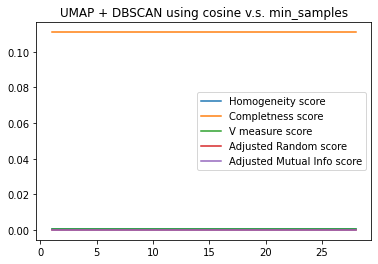

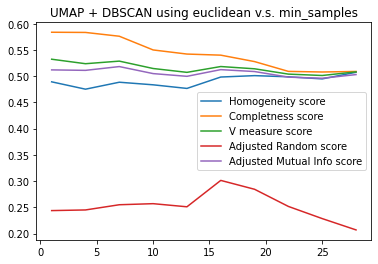

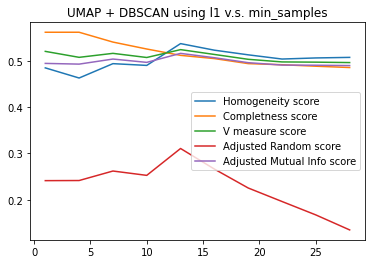

In [12]:
umap_homos = []
umap_comp = []
umap_v_measure = []
umap_adj_rand = []
umap_adj_mutual_info = []

metrics = ["cosine", "euclidean", "l1"]
min_sampleVals = list(range(1, 30, 3))
optimalEpsVal = {"cosine":0.5, "euclidean":0.3, "l1":0.5}

for metric_ in metrics:
  for min_samplesVal in min_sampleVals:
    epsVal = optimalEpsVal[metric_]
    clustering = DBSCAN(min_samples=min_samplesVal, eps=epsVal, metric=metric_)
    clustering_data = clustering.fit(embedding)
    
    umap_homos.append(homogeneity_score(dataset_20.target, clustering_data.labels_))
    umap_comp.append(completeness_score(dataset_20.target, clustering_data.labels_))
    umap_v_measure.append(v_measure_score(dataset_20.target, clustering_data.labels_))
    umap_adj_rand.append(adjusted_rand_score(dataset_20.target, clustering_data.labels_))
    umap_adj_mutual_info.append(adjusted_mutual_info_score(dataset_20.target, clustering_data.labels_))

interval = len(min_sampleVals)
for index, metric_ in enumerate(metrics):
  plt.title('UMAP + DBSCAN using ' + metric_ + " v.s. min_samples") 
  plt.plot(min_sampleVals, umap_homos[index*interval:(index+1)*interval], label='Homogeneity score')
  plt.plot(min_sampleVals, umap_comp[index*interval:(index+1)*interval], label='Completness score')
  plt.plot(min_sampleVals, umap_v_measure[index*interval:(index+1)*interval], label='V measure score')
  plt.plot(min_sampleVals, umap_adj_rand[index*interval:(index+1)*interval], label='Adjusted Random score')
  plt.plot(min_sampleVals, umap_adj_mutual_info[index*interval:(index+1)*interval], label='Adjusted Mutual Info score')
  plt.legend(loc='best')
  plt.show()

In [14]:
umap_homos = {}
umap_comp = {}
umap_v_measure = {}
umap_adj_rand = {}
umap_adj_mutual_info = {}

epsVals = [x*0.1 for x in range(3, 8)]
# pVals = [None, 1, 0.25] all the same
metrics = ["cosine", "euclidean", "l1"]
min_sampleVals = list(range(1, 100, 5))

for metric_ in metrics:
  for epsVal in epsVals:
    for min_samplesVal in min_sampleVals:
      clustering = DBSCAN(min_samples=min_samplesVal, eps=epsVal, metric=metric_)
      clustering_data = clustering.fit(embedding)
      
      umap_homos[(metric_, epsVal, min_samplesVal)] = homogeneity_score(dataset_20.target, clustering_data.labels_)
      umap_comp[(metric_, epsVal, min_samplesVal)] = completeness_score(dataset_20.target, clustering_data.labels_)
      umap_v_measure[(metric_, epsVal, min_samplesVal)] = v_measure_score(dataset_20.target, clustering_data.labels_)
      umap_adj_rand[(metric_, epsVal, min_samplesVal)] = adjusted_rand_score(dataset_20.target, clustering_data.labels_)
      umap_adj_mutual_info[(metric_, epsVal, min_samplesVal)] = adjusted_mutual_info_score(dataset_20.target, clustering_data.labels_)



In [21]:
sorted(list(umap_v_measure.items()),key=lambda x: x[1], reverse=True)

[(('l1', 0.30000000000000004, 1), 0.536767416805637),
 (('l1', 0.4, 1), 0.5350769127025484),
 (('euclidean', 0.30000000000000004, 1), 0.5323249282367839),
 (('euclidean', 0.30000000000000004, 6), 0.5305325650874166),
 (('euclidean', 0.5, 46), 0.5266245996288075),
 (('l1', 0.5, 6), 0.5249692496938732),
 (('euclidean', 0.5, 51), 0.523515881729524),
 (('euclidean', 0.5, 96), 0.521919002737884),
 (('l1', 0.5, 1), 0.5207853664639199),
 (('l1', 0.7000000000000001, 21), 0.5198301230469909),
 (('euclidean', 0.6000000000000001, 81), 0.519413935015391),
 (('euclidean', 0.5, 56), 0.5188290201202477),
 (('euclidean', 0.6000000000000001, 76), 0.5185491314289563),
 (('l1', 0.4, 6), 0.5184015348350596),
 (('euclidean', 0.30000000000000004, 16), 0.5183921495995183),
 (('euclidean', 0.6000000000000001, 86), 0.5183882233047757),
 (('l1', 0.7000000000000001, 16), 0.5177162324542831),
 (('l1', 0.4, 11), 0.5175935975173072),
 (('euclidean', 0.4, 41), 0.5169710783788181),
 (('l1', 0.5, 11), 0.51675759799598

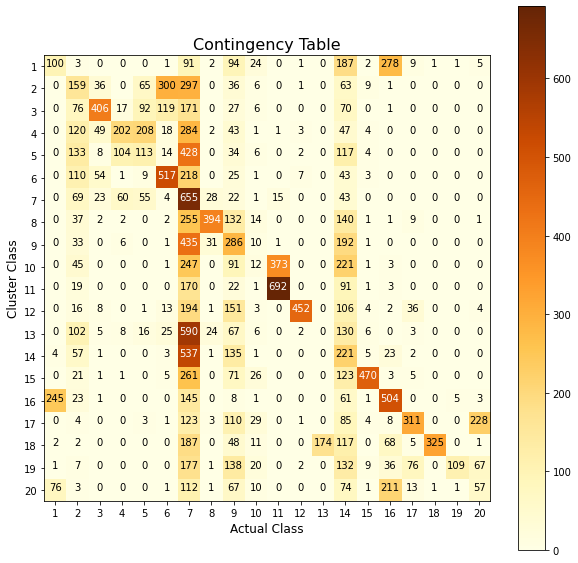

In [20]:
clustering = DBSCAN(min_samples=1, eps=0.3, metric='l1')
clustering_data = clustering.fit(embedding)
newCm = []
for index, i in enumerate(cm):
  if i.sum() != 0:
    newCm.append(i)
newCm = np.array(newCm)
rows, cols = linear_sum_assignment(newCm, maximize=True) 
x=newCm[rows[:, np.newaxis], cols]
plot_contingency_table_20(x)

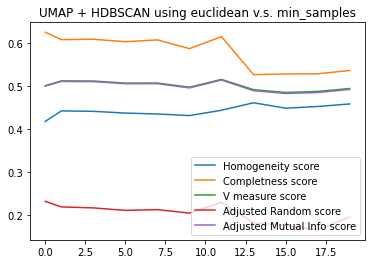

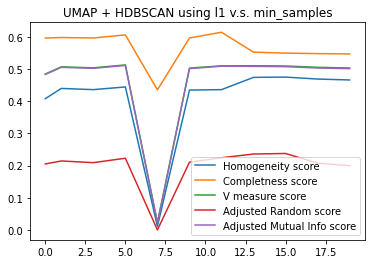

In [22]:
import hdbscan

umap_homos = []
umap_comp = []
umap_v_measure = []
umap_adj_rand = []
umap_adj_mutual_info = []

# pVals = [None, 1, 0.25] all the same
metrics = ["euclidean", "l1"]
min_sampleVals = [None] + list(range(1, 20, 2))

for metric_ in metrics:
  for min_samplesVal in min_sampleVals:
    clustering = hdbscan.HDBSCAN(metric=metric_, min_samples=min_samplesVal, min_cluster_size=100)
    clustering_data = clustering.fit(embedding)
    
    umap_homos.append(homogeneity_score(dataset_20.target, clustering_data.labels_))
    umap_comp.append(completeness_score(dataset_20.target, clustering_data.labels_))
    umap_v_measure.append(v_measure_score(dataset_20.target, clustering_data.labels_))
    umap_adj_rand.append(adjusted_rand_score(dataset_20.target, clustering_data.labels_))
    umap_adj_mutual_info.append(adjusted_mutual_info_score(dataset_20.target, clustering_data.labels_))

interval = len(min_sampleVals)
modMin_sampleVals = [0] + min_sampleVals[1:]
for index, metric_ in enumerate(metrics):
  plt.title('UMAP + HDBSCAN using ' + metric_ + " v.s. min_samples") 
  plt.plot(modMin_sampleVals, umap_homos[index*interval:(index+1)*interval], label='Homogeneity score')
  plt.plot(modMin_sampleVals, umap_comp[index*interval:(index+1)*interval], label='Completness score')
  plt.plot(modMin_sampleVals, umap_v_measure[index*interval:(index+1)*interval], label='V measure score')
  plt.plot(modMin_sampleVals, umap_adj_rand[index*interval:(index+1)*interval], label='Adjusted Random score')
  plt.plot(modMin_sampleVals, umap_adj_mutual_info[index*interval:(index+1)*interval], label='Adjusted Mutual Info score')
  plt.legend(loc='best')
  plt.show()

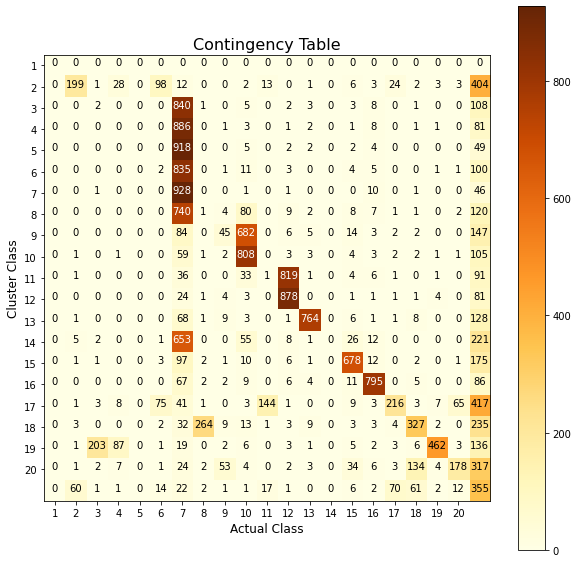

In [24]:
clustering = hdbscan.HDBSCAN(min_cluster_size=100, metric="euclidean", min_samples=9)
clustering_data = clustering.fit(embedding)
cm = confusion_matrix(dataset_20.target, clustering_data.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True) 
x=cm[rows[:, np.newaxis], cols]
plot_contingency_table_20(x)